# Face Recognition Pipeline [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/likeshadows42/loki)

This demo shows a step-by-step face recognition pipeline. More functionalities can be added or change as the project evolves and matures.
The main approach here was dividing the face detection and face recognition steps into 2 separate process. The deepface framework tacitly assumes that each picture contains a single person, which consequently allowed the face detector and recognition steps to be wrapped into a single function.

### Setup

In [1]:
!pip install deepface

In [2]:
# Module / package imports
import os
import cv2
import time
import shutil
import pickle
import zipfile
import tarfile
import requests
import itertools
import numpy              as np
import pandas             as pd
import matplotlib.pyplot  as plt
import matplotlib.image   as mpimg
import matplotlib.patches as patches
import tensorflow         as tf

from tqdm                    import tqdm
from deepface                import DeepFace
from deepface.basemodels     import VGGFace, OpenFace, Facenet, Facenet512,  \
                                    FbDeepFace, DeepID, DlibWrapper, ArcFace,\
                                    Boosting
from deepface.extendedmodels import Age, Gender, Race, Emotion
from deepface.commons        import functions, realtime, distance as dst
from deepface.detectors      import FaceDetector

tf_version = int(tf.__version__.split(".")[0])

if tf_version == 2:
    import logging
    tf.get_logger().setLevel(logging.ERROR)
    from tensorflow.keras.preprocessing import image
else:
    from keras.preprocessing import image

from PIL                     import Image
from io                      import BytesIO
from deepface                import DeepFace
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay

# ==============================================================================

class FR_performance:
    """
    Face recognition performance class. Stores performance results and metrics
    for the face recognition system using the specified face detector and
    verifier.
    
    Attributes:
        - On initialization:
            1. name - name of result (typically 
                <face detector>_plus_<face verifier>)
            2. files - name of files relating to these results
            3. pred - predictions or face recognition system output (vector
                of booleans representing match / no match for each file)
                    
        - After successful 'calc_performance' call:
            4. acc - system's accuracy as a decimal
            5. cm  - system's confusion matrix
            6. tn  - system's true  negatives (absolute value)
            7. fp  - system's false positives (absolute value)
            8. fn  - system's false negatives (absolute value)
            9. tp  - system's true  positives (absolute value)
            
        - After successful 'plot_performance' call:
            10. txt  - text printed on the performance
            11. disp - handle to performance plot
            
    Methods:
        calc_performance(ground_truth) - calculates the performance of the 
            face recognition system by comparing the system's results with
            the ground truth provided.
            
        plot_performance() - plots a confusion matrix showing the system's
            performance, along with some important metrics: false positives,
            false negatives, true positives, true negatives and accuracy.
    """
    def __init__(self, name, output):
        """
        Initializes the face recognition performance object.
        
        Inputs:
            1. name - name of result
            2. output - dictionary containing the file names and results
            
        Outputs:
            Updates the following attributes:
                a. name
                b. files
                c. pred
        """
        self.name  = name
        self.files = output["file"]
        self.pred  = output["result"]
        
    def calc_performance(self, ground_truth):
        """
        Calculates the performance of the face recognition system by
        comparing the system's results with the ground truth provided.
        
        Input:
            1. ground_truth - array of boolean values indicating if
                the specific file has a match in the gallery or not
                
        Outputs:
            Updates the following attributes:
                a. pred
                b. acc
                c. cm
                d. tn
                e. fp
                f. fn
                g. tp
        """
        # Converts predictions to numpy array if they are not
        if not isinstance(self.pred, np.ndarray):
            self.pred = np.array(self.pred)
            
        # Calculating accuracy
        if not isinstance(ground_truth, np.ndarray):
            ground_truth = np.array(ground_truth)   
        self.acc = np.sum(ground_truth == self.pred) \
                 / ground_truth.shape[0]
        
        # Calculating confusion matrix and other performance metrics
        self.cm = confusion_matrix(ground_truth, self.pred)
        self.tn, self.fp, self.fn, self.tp = self.cm.ravel()
        
    def plot_performance(self):
        """
        Plots a confusion matrix showing the system's performance, along
        with some important metrics: false positives, false negatives,
        true positives, true negatives and accuracy.
        
        Input:
            None
                
        Outputs:
            Updates the following attributes:
                a. txt
                b. disp
        """
        try:
            # Creating performance text
            self.txt = "Accuracy: {:.3f}%".format(100*self.acc).center(30) \
                     + "\n" + f"True positive: {self.tp}".rjust(20)        \
                     + f" | False positive: {self.fp}".rjust(20) + "\n"    \
                     + f"True negative: {self.tn}".rjust(20)               \
                     + f" | False negative: {self.fn}".rjust(20)

            # Create confusion matrix display
            self.disp = ConfusionMatrixDisplay(confusion_matrix=self.cm,
                                       display_labels=["negative", "positive"])
            
            # Plots the results & text
            self.disp.plot(cmap="Blues")
            plt.figtext(0.5, -0.2, self.txt, wrap=True,
                        horizontalalignment='center', fontsize=12);
            plt.title(self.name);
            
        except Exception as excpt:
            print(excpt)  # print exception
            print(f"Type: {type(excpt)} | Args: {excpt.args}")
            print("Try calling 'calc_performance' once then calling this method.")
            
# ============================================================================

class DownloadExtract:
  """
  Simple class to download and extract zip, tar or tar.gz file from url.
  """

  def download_and_extract(url, destination, file_is="", verbose=0):
    """
    Downloads and extracts a zip, tar, tar.gz or tgz file from the specified
    'url' to the destination folder 'destination'. If the file specified is not 
    one of those types then this method aborts with a warning.

    Inputs:
      1. url - string specifying the file's URL.

      2. destination - string specifying a target directory for extraction.

      3. file_is - string specifying the file type ([], zip, tar or tar.gz).
         If file_is='' is used then this function tries to determine the file
         type automatically from the file's URL.

      4. verbose - controls the text output of the function ([0 = quiet],
         1 = verbose).
    
    Outputs:
      None
    
    Example call:
      DownloadExtractZip.download_and_extract(url, destination, verbose=0)
    """
    # Variable to skip last verbose statement
    skip_last_msg = False

    # Assigns a file_type number according to the 'file_is' input
    if file_is == 'zip':
      file_type = 1
    elif file_is == 'tar':
      file_type = 2
    elif file_is == 'tar.gz' or file_is == 'tgz':
      file_type = 3
    else:
      file_type = 0

    if verbose:
      print('Downloading Started')
    
    # Downloading the file by sending the request to the URL
    req = requests.get(url, allow_redirects=True)
    if verbose:
      print('Downloading Completed\nExtracting ...', end=' ')

    # Determines file type from url and extracts the file
    if url.endswith("zip") or file_type == 1:
      zfile = zipfile.ZipFile(BytesIO(req.content))
      zfile.extractall(destination)

    elif url.endswith("tar") or file_type == 2:
      tar = tarfile.open("r:", fileobj=BytesIO(req.content))
      tar.extractall(destination)
      tar.close()

    elif url.endswith("tar.gz") or url.endswith("tgz") or file_type == 3:
      tar = tarfile.open("r:gz", fileobj=BytesIO(req.content))
      tar.extractall(destination)
      tar.close()

    else:
      skip_last_msg=True
      print('failed!\n[Error] File type was not recognized \
            (not zip, tar, tar.gz or tgz)')

    if verbose and not skip_last_msg:
      print('done!')

# ==============================================================================

# Create directory function
def create_dir(dir_path):
  """
  Creates a directory at the specified directory path 'dir_path' IF it does not
  exist. Returns a status of 0 is the directory was successfully created and 
  returns a status of 1 if a directory already exists.

  Inputs:
    1. dir_path - directory path of new directory.
    
  Outputs:
    1. status - 0 to indicate success (directory creation) or 1 to indicate
       failure (directory already exists)
    
  Example call:
    status = create_dir("./this/is/a/directory/path")
  """
  # Create directory
  try:
    os.makedirs(dir_path)
    status = 0
  except FileExistsError:
    # Directory already exists
    status = 1

  return status

# ==============================================================================

def split_single_multiple_imgs(dataset_dir):
    """
    Splits the LFW data set into two sets:
        1. single - each person has only a SINGLE image
        2. multiple - each person has MULTIPLE images (>1)

    Input:
        1. dataset_dir - full path of the LFW data set directory

    Output:
        1. dictionary containing the names of the directories:
            a. Of people with only 1 image (key: 'single')
            b. Of people with more than 1 images (key: 'multiple')

    Example call:
        splits = split_single_multiple_imgs(dataset_dir)
        splits['single']   # these directories contain only 1 image
        splits['multiple'] # these directories contain >1 images
    """

    # Initializes lists
    multiple_imgs = []
    single_img    = []

    # Loops through each directory
    for dir in os.listdir(dataset_dir):
        dir_fp = os.path.join(dataset_dir, dir) # gets full path

        # Only consider directories (ignore files)
        if os.path.isdir(dir_fp):
            nfiles = len(os.listdir(dir_fp)) # number of files in directory

            # Determines if the directory has multiple images and assigns it
            # to the appropriate list
            if nfiles > 1:
                multiple_imgs.append(dir)
            else:
                single_img.append(dir)

    return {"single":single_img, "multiple":multiple_imgs}

# ==============================================================================

def create_sub_LFW(save_path, dataset_root, p1_idxs=[], p1_num=100, p2_num=100,
                    p2_idxs=[], force_create=False):
    """
    Creates a subset of the LFW data set. This subset consists of a mixture of:
        1. 'p1_num' directories of people with only 1 image available.
        2. 'p2_num' directories of people with >1 images available.

    These directories are 'linearly' sampled. Alternatively, the user can
    provide a numpy array of indices corresponding to which subdirectories 
    they wish to include in the subset. Note that 'p1_idxs' and 'p2_idxs'
    correspond indices of subdirectories described as above and if they are
    provided then 'p1_num' and 'p2_num' have no effect.

    For example:
        p1_idxs = numpy.array([1, 2])    -> ignores 'p1_num'
        p2_idxs = numpy.array([1, 2, 3]) -> ignores 'p2_num'

    Result in:
        The subset will consist of the first 2 subdirectories with only 1 image
        and the first 3 subdirectories with more than 1 images.

    In all cases, the first image of EACH subdirectory that has multiple images
    will be used to create the gallery (known faces). Everything else will be
    treated as faces in the wild, called targets (unknown faces)

    The 'force_create' flag controls if this function should create the subset
    even if 'save_path' points to an already existing directory (assumed to be a
    pre-existing data set). Note that if force_create=True then the old data set
    is DELETED - so use it with care!

    Inputs:
        1. save_path - full path to location of the new data set

        2. dataset_root - full path of the LFW data set

        3. p1_idxs - numpy array of indices that determine which subdirectories
            of people with 1 image should be included. If not provided, then
            'p1_num' linearly-spaced subdirectories are selected ([p1_idxs=[]]).

        4. p1_num - number of single image subdirectories to be selected
            ([p1_num=100])

        5. p2_idxs - numpy array of indices that determine which subdirectories
            of people with >1 images should be included. If not provided, then
            'p2_num' linearly-spaced subdirectories are selected ([p2_idxs=[]]).

        6. p2_num - number of multiple image subdirectories to be selected
            ([p2_num=100])

        7. force_create - flag indicating if this function should create the
            data set even if a directory exists in 'save_path'. This function
            assumes that a directory in 'save_path' is a data set. If 
            'force_create=True', IT WILL DELETE EVERYTHING IN 'save_path', so
            use it with caution ([force_create=False])!

    Output:
        None (creates a data set at 'save_path')

    Example call:
        SAVE_PATH = I/want/to/save/the/dataset/here
        LFW_ROOT  = this/is/where/LFW/is/located

        # Creating custom indicies
        p1_idxs = numpy.array([1, 2])
        p2_idxs = numpy.array([1, 2, 3, 4, 5])

        # This will result in a very small subset of LFW
        create_sub_LFW(SAVE_PATH, LFW_ROOT, p1_idxs=p1_idxs, p2_idxs=p2_idxs)
    """

    if os.path.isdir(save_path) and not force_create:
        # Aborts creating the data set as it already exists
        print("LFW subset data set already exists!")
        return None
    
    elif os.path.isdir(save_path) and force_create:
        # Since 'force_create' is True, delete the previous data set found
        print("Forcing the creation of the data set. " \
              + "Removing existing data set.")
        shutil.rmtree(save_path) # should aways work because 'save_path' exists

    else:
        # Otherwise the data set does not exist, so proceed with creating it.
        # This is similar to when 'force_create=True' but without the need to 
        # delete the previous data set (because there isnt any).
        #       - This is kept here to improve code reability / understanding
        pass

    # -------------------------------------------------------------------------

    # Creates the new dataset root directory
    gallery_path = os.path.join(save_path, "gallery")
    targets_path = os.path.join(save_path, "targets")

    os.mkdir(save_path)    # path to the new dataset
    os.mkdir(gallery_path) # path to the 'known'   people (gallery)
    os.mkdir(targets_path) # path to the 'unknown' people (targets)

    # -------------------------------------------------------------------------

    # Splits dataset into people with a single image and people with multiple
    # images
    splits   = split_single_multiple_imgs(dataset_root)
    single   = splits["single"]
    multiple = splits["multiple"]

    # Create partition arrays (if not provided). If provided assumes it is
    # properly constructed... maybe it shouldnt?
    if not isinstance(p1_idxs, np.ndarray):
        p1_idxs = np.linspace(0,   len(single)-1, num=p1_num).astype(int)

    if not isinstance(p2_idxs, np.ndarray):
        p2_idxs = np.linspace(0, len(multiple)-1, num=p2_num).astype(int)
    
    # -------------------------------------------------------------------------

    # First we will deal with single images
    for idx in p1_idxs:
        source_path  = os.path.join(dataset_root, single[idx])
        targets_path = os.path.join(save_path, "targets", single[idx])

        # Copy the entire directory
        try:
            shutil.copytree(source_path, targets_path)
        except Exception as excpt:
            print("Type: ", type(excpt),
                  " | Arguments: ", excpt.args,
                  " | Exception: ", excpt)

    # -------------------------------------------------------------------------

    # Then we will deal with multiple images and create the gallery:
    for idx in p2_idxs:
        source_path  = os.path.join(dataset_root, multiple[idx])
        gallery_path = os.path.join(save_path, "gallery", multiple[idx])
        targets_path = os.path.join(save_path, "targets", multiple[idx])
    
        # Create a directory in gallery and targets with person's name if needed
        if not os.path.isdir(gallery_path):
            os.mkdir(gallery_path)
    
        if not os.path.isdir(targets_path):
            os.mkdir(targets_path)

        # We will use the first file to build our gallery
        # Get the files inside the current directory
        file_names = os.listdir(source_path)
        for j, name in enumerate(file_names):

            try:
                if j == 0:
                    shutil.copy2(os.path.join(source_path , name), 
                                 os.path.join(gallery_path, name))
                else:
                    shutil.copy2(os.path.join(source_path , name), 
                                 os.path.join(targets_path, name))
            except FileNotFoundError:
                pass

    return None

# ==============================================================================

def get_LFW_ground_truth(dataset_root):
    """
    Gets the ground truth from the LFW data set (or subsets assuming they
    have the same structure). Returns the ground truth names (ids), targets
    names (ids) and each targets' match to the ground truth.
    
    Input:
        1. dataset_root - full path to the root directory of the LFW data set
    
    Outputs:
        1. list with each person's name in the gallery
        2. dictionary where each file name is a key and has a corresponding
            boolean (item) indicating if this file has a positive match in
            the gallery
            
    Example call:
        LFW_ROOT = this/is/my/path/to/the/LFW/data_set
        gt_ids, tgt_ids, tgt_mtch = get_LFW_ground_truth(LFW_ROOT)
    """
    # Sets up the gallery and targets paths
    gallery_dir = os.path.join(dataset_root, "gallery")
    targets_dir = os.path.join(dataset_root, "targets")
    
    # Loops through all directories in 'gallery', obtaining the ground truth
    # from the directory names
    gt_ids = []
    for root, dirs, _junk in os.walk(gallery_dir):
        for name in dirs:
            files = os.listdir(os.path.join(root, name))
            # The file names are Name_Surname_XXXX.jpg so just ignore the last
            # 9 characters (as we dont need _XXXX.jpg, just the person's name)
            gt_ids.append(files[0][:-9].lower())
     
    # Loops through all directories in 'target', obtaining the targets' names
    # from the directory names and trying to match them to the ground truths
    tgt_mtch = dict()
    for root, dirs, _junk in os.walk(targets_dir):
        for name in dirs:
            files = os.listdir(os.path.join(root, name))
            # The file names are Name_Surname_XXXX.jpg so just ignore the last
            # 9 characters (as we dont need _XXXX.jpg, just the person's name)
            for file in files:
                file = file[:-4].lower() # gets the file name without extension
                
                # Append the new number to the existing array at this slot
                tgt_mtch[file] = file[:-5] in gt_ids
                
    
    return gt_ids, tgt_mtch

# ==============================================================================

def evaluate_FR_on_LFW(dataset_root, model_name="VGG-Face",
                       detector_backend="opencv", show_prog=True):
    """
    Evaluates the facial recognition system on the LFW data set (or subset,
    assuming it has the same structure as LFW) using the specified face
    verification model ('model_name') and face detector model
    ('detector_backend'). A progress bar is shown if 'show_prog=True'.
    
    Inputs:
        1. dataset_root - full path of the LFW data set (or subset) root
        2. model_name - face verification model name ([VGG-Face], Facenet, 
            Facenet512, OpenFace, DeepFace, DeepID, ArcFace, Dlib)
        3. detector_backend - face detector model name ([opencv], ssd, dlib,
            mtcnn, retinaface, mediapipe)
        4. show_prog - flag indicating if progress bars should be shown
            ([show_prog=True])
            
    Output:
        1. dictionary containing the file names (key: 'file'), ground truth
            boolean value indicating if there is a match in the gallery (key:
            'gt') and boolean value indicating if the face recognition system
            found a match in the gallery (key: 'results')
            
    Note: 'results' can be interpreted as "predictions".
    
    Example call:
        LFW_ROOT = this/is/my/path/to/the/LFW/data_set
        output = evaluate_FR_on_LFW(dataset_root, model_name="Facenet",
                                  detector_backend="retinaface", show_prog=True)
    """
    # Sets up the gallery and targets paths
    gallery_path = os.path.join(dataset_root, "gallery")
    targets_path = os.path.join(dataset_root, "targets")
    
    # ------------------------------------------------------------------------
    
    # Gets the ground truths from the LFW data set
    gt_ids, tgt_mtch = get_LFW_ground_truth(dataset_root)
    
    # ------------------------------------------------------------------------
    
    # Gets all targets
    all_targets = []
    for root, dirs, _junk in os.walk(targets_path):
        for i, dir in enumerate(dirs):
            files = os.listdir(os.path.join(root, dir))
            for file in files:
                all_targets.append(os.path.join(root, dir, file))
                
    # ------------------------------------------------------------------------

    # Applies face recognition
    results = DeepFace.find(img_path = all_targets,
                            db_path = gallery_path,
                            model_name = model_name,
                            detector_backend = detector_backend,
                            enforce_detection = False,
                            prog_bar = not show_prog) # dunno why prog_bar is inverted
    
    # ------------------------------------------------------------------------

    # Process results
    output = {"file": [], "result":[], "gt":[]} # initializes dictionary
    for name, result in zip(all_targets, results):
        # Processes and stores the file name
        name = name.split("/")[-1][:-4].lower() # extracts file's name
        output["file"].append(name)
    
        # If the current result dataframe is empty than no match was
        # found (False), otherwise a match was found (True)
        output["result"].append(not result.empty)
    
        # Given the target name, searches the ground truth in the
        # 'tgt_mtch' dictionary
    
        output["gt"].append(tgt_mtch[name])
        
    return output

# ==============================================================================

def get_and_plot_performance(predictions, ground_truth):
    """
    Gets performance data and plots the confusion matrix as a performance
    indicator. Returns the confusion matrix plot and a dictionary containing
    the accuracy, true negative, false positive, false negative, true positive
    and confusion matrix.
    
    Inputs:
        1. predictions  - prediction list or numpy array of boolean values
        2. ground_truth - ground_truth list or numpy array of boolean values
        
    Outputs:
        1. handle to the confusion matrix plot
        2. dictionary with:
            a. 'acc': accuracy
            b. 'tn': true negative
            c. 'fp': false positive
            d. 'fn': false negative
            e. 'tp': true positive
            f. 'cm': confusion matrix
            
    Example call:
        disp, perf = get_and_plot_performance(pred, gts)
    """
    # Creating the confusion matrix and calculating accuracy,
    # true negative, true positive, false negative and false positive
    acc            = 100 * np.sum(np.array(ground_truth) ==   \
                              np.array(predictions))          \
                     / len(ground_truth)
    cm             = confusion_matrix(ground_truth, predictions)
    tn, fp, fn, tp = cm.ravel()
    
    # Creating performance text
    txt = "Accuracy: {:.3f}%".format(acc).center(30) + "\n" \
        + f"True positive: {tp}".rjust(20)                  \
        + f" | False positive: {fp}".rjust(20) + "\n"       \
        + f"True negative: {tn}".rjust(20)                  \
        + f" | False negative: {fn}".rjust(20) + "\n"       \
        + "=" * 40 + "\n"

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=["negative", "positive"])
    disp.plot(cmap="Blues")
    plt.figtext(0.5, -0.2, txt, wrap=True, 
                horizontalalignment="center", fontsize=12);
    
    return disp, {'acc': acc, 'tn':tn, 'fp':fp, 'fn':fn, 'tp':tp, 'cm':cm}

# ============================================================================

def exhaustive_LFW_eval(dataset_root, backends=[], models=[], show_prog=True):
    """
    Exhaustive evaluation of the LFW data set (or any subset with the same
    structure). In this case, exhaustive means all the unique pair-wise
    combination of all available backends and models. The following default
    backends and models are used if customs lists are not provided:
    
        backends = [ "opencv", "ssd", "dlib", "mtcnn", "retinaface"]
        models   = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", 
                    "DeepFace", "DeepID", "ArcFace", "Dlib", "Ensemble"]
    
    Inputs:
        1. dataset_root - full path of the LFW data set (or subset) root
        2. models - list of face verification model(s) ([models=[]])
        3. backends - list of face detector model(s) ([backends=[]])
        4. show_prog - flag indicating if progress bars should be shown
            ([show_prog=True])
            
    Outputs:
        1. list of 'FR_performance' objects, one for each face recognition
            system. See the docstring of FR_perfomance class for more
            information about these objects.
        2. gt - array of boolean values indicating if the specific file has a
            match in the gallery or not
    """
    if len(backends) == 0:
      backends = ["opencv", "ssd", "dlib", "mtcnn", "retinaface"]
            
    if len(models) == 0:
      models   = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", \
                  "DeepFace", "DeepID", "ArcFace", "Dlib", "Ensemble"]
    
    # This function implements a pair-wise combinatorial generator:
    # list1 = [a, b, c], list2 = [1, 2] then pairs(list1, list2)
    # is a generator that outputs: (a, 1), (a, 2), (b, 1), (b, 2)
    # (c, 1), (c, 2)
    def pairs(*lists):
      for t in itertools.combinations(lists, 2):
        for pair in itertools.product(*t):
          yield pair
    
    gt               = [] # need to initialize to avoid unbound error
    all_perf_results = []

    for i, pair in enumerate(pairs(models, backends)):   # skipping opencv, ssd, dlib because they fail to detect faces and break everythingprint
      print(f"Face detector: {pair[1]}\nFace verifier: {pair[0]}\n")
        
      output   = evaluate_FR_on_LFW(dataset_root,
                                    model_name=pair[0],
                                    detector_backend=pair[1],
                                    show_prog=show_prog)
        
      print(" ")
        
      # The ground truth is always the same (as the data set is
      # unchanged) so just store it once
      if i == 0:
        gt = output["gt"]
        
      # Create FR_performance object, then calculate performance
      cur_perf = FR_performance(pair[1] + "_plus_" + pair[0], output)
      cur_perf.calc_performance(gt)
        
      # Append the object to the all performance results list
      all_perf_results.append(cur_perf)
            
    return all_perf_results, gt

# ============================================================================

def download_image(url, save_path):
    r   = requests.get(url)
    ext = url.split('.')[-1].lower()
    if r.status_code == 200:
        with open(save_path + '.' + ext, "wb") as file:
        file.write(r.content)

# ============================================================================


    

In [3]:
# Setting up important paths and constants
ROOT_DIR     = os.path.dirname(os.path.realpath("__file__"))
DATASETS_DIR = os.path.join(ROOT_DIR.split('loki')[0], 'datasets')

#                0    ,     1    ,      2      ,     3     ,      4      ,      5     ,     6    ,   7
BACKENDS = [  "opencv",     "ssd",       "dlib",    "mtcnn", "retinaface", "mediapipe"]
MODELS   = ["VGG-Face", "Facenet", "Facenet512", "OpenFace",   "DeepFace",    "DeepID", "ArcFace", "Dlib"]

if len(tf.config.list_physical_devices('GPU')) == 0:
  print('!!! WARNING !!!: No GPU found! This script might take longer\
  than expected if executed using only CPUs!')


# Creating testing data

First, we download the Labelled Faces in the Wild (LFW) data set and create a subset of this data set. In this subset, we create a gallery (known faces) and a targets directory (unknown faces).

This step is skipped if the data set has been downloaded and the subset data set (called LFW_sub) already exists.

We will use a **very small** subset just for testing purposes.

CHANGE THIS DESCRIPTION AFTERWARDS

In [4]:
# Testing data creation flags
skip_dataset_creation   = True
skip_url_image_download = False

# Testing data paths
datasets_dir = DATASETS_DIR

# Creating dataset directory
if create_dir(datasets_dir):
    print(f'Dataset directory already exists! ({datasets_dir})')
else:
    print(f'Creating dataset directory. ({datasets_dir})')

# Dataset creation
if not skip_dataset_creation:
    # Creating the base data set directory if needed
    if create_dir(DATASETS_DIR):
        print(f"{DATASETS_DIR} already exists! Continuing...\n")

    LFW_DIR = os.path.join(DATASETS_DIR, "lfw")

    # Download and extract LFW images
    if os.path.isdir(LFW_DIR):
        print(f"{LFW_DIR} already exists. Skipping LFW data set download...")
    else:
        print("  > Downloading LFW images:")
        DownloadExtract.download_and_extract("http://vis-www.cs.umass.edu/lfw/lfw.tgz", DATASETS_DIR, verbose=1)

    print(" ")

    # Set important paths
    LFW_SUB_ROOT = os.path.join(DATASETS_DIR, "LFW_sub")
    GALLERY_PATH = os.path.join(LFW_SUB_ROOT, 'gallery')
    TARGETS_PATH = os.path.join(LFW_SUB_ROOT, 'targets')

    # Create LFW subset
    print('Creating subset for testing ... ', end='')
    create_sub_LFW(LFW_SUB_ROOT, LFW_DIR, p1_num=2, p2_num=4)
    print('done!\n', '='*80, '\n', sep='')

    # Exposing the files in the subset:
    print('Gallery files:')
    %ls $GALLERY_PATH
    print('\nTargets files:')
    %ls $TARGETS_PATH
    print('\n', '='*80, '\n', sep='')
else:
    print('Dataset creation skipped (check "skip_dataset_creation")')
    
print('\n', '-'*80, '\n')

# Web image download
if not skip_url_image_download:
    # Create paths to web images dataset
    WEB_IMGS_ROOT      = os.path.join(DATASETS_DIR, 'web_imgs')
    WEB_IMGS_RAW       = os.path.join(WEB_IMGS_ROOT, 'raw')
    WEB_IMGS_GALLERY   = os.path.join(WEB_IMGS_ROOT, 'gallery')
    WEB_IMGS_TARGETS   = os.path.join(WEB_IMGS_ROOT, 'targets')
    web_images_dataset = WEB_IMGS_ROOT
    
    # Creating dataset directories
    for dir in [WEB_IMGS_ROOT, WEB_IMGS_RAW, WEB_IMGS_GALLERY, WEB_IMGS_TARGETS]:
        if create_dir(dir):
            print(f'Directory already exists: {dir}')
        else:
            print(f'Creating directory: {dir}')
    print('')
    
    # Obtain images from the web with 2 or more people
    print('Downloading images from the web ... ', end='')
    urls = ['https://upload.wikimedia.org/wikipedia/commons/a/ad/Angelina_Jolie_2_June_2014_%28cropped%29.jpg',
            'https://i.dailymail.co.uk/1s/2019/12/11/17/22111972-0-image-a-27_1576085265364.jpg',
            'https://images.hindustantimes.com/img/2021/09/04/550x309/Angelina_Jolie_Brad_Pitt_1630772740300_1630772749308.JPG',
            'https://media.gq.com/photos/56ab174ccb255f772517bfe7/16:9/w_2560%2Cc_limit/GettyImages-114502416.jpg']

    WEB_IMG_PATHS = []
    for i, url in enumerate(urls):
        save_path = os.path.join(WEB_IMGS_RAW, f'angelina_jolie_{i}')
        WEB_IMG_PATHS.append(save_path + '.jpg')
        download_image(url, save_path)
        
    print('done!')
else:
    print('Web images download skipped (check "skip_url_image_download")')

Dataset directory already exists! (/home/studio-lab-user/datasets)
Dataset creation skipped (check "skip_dataset_creation")

 -------------------------------------------------------------------------------- 

Directory already exists: /home/studio-lab-user/datasets/web_imgs
Directory already exists: /home/studio-lab-user/datasets/web_imgs/raw
Directory already exists: /home/studio-lab-user/datasets/web_imgs/gallery
Directory already exists: /home/studio-lab-user/datasets/web_imgs/targets



# New Face Recognition Pipeline

Here we attempt to create a new face recognition pipeline trying to make each significant step as modular as possible.

### Pipeline Functions

In [5]:
def get_image_paths(root_path, file_types=('.jpg', '.png')):
    """
    Gets the full paths of all 'file_types' files in the 'root_path' directory and
    its subdirectories.

    Inputs:
        1. root_path  - full path of a directory
        2. file_types - tuple containing strings of file extensions
            ([file_types=('.jpg', '.png')])

    Output:
        1. list containing full path of all files in the directory and its
            subdirectories

    Example call:
        ROOT_PATH = path/to/some/folder/dude
        all_images = get_image_paths(ROOT_PATH, file_types=('.png'))
    """
    # Gets all images in this root directory
    all_images = []
    for root, _junk, files in os.walk(root_path):
        # Processes files in the root directory - can be transformed into a list
        # comprehension but code might lose clarity
        for file in files:
            if file.lower().endswith(file_types):
                exact_path = os.path.join(root, file)
                all_images.append(exact_path)
      
    return all_images

# =============================================================================

def detect_faces(img_path, detector_backend = 'opencv',
                 align = True, return_type = 'both'):
    """
    Detects faces in an image (and optionally aligns them).
    
    Inputs:
        1. img_path - image path, base64 image or numpy array image
        2. detector_backend - string corresponding to detector ([opencv],
            ssd, dlib, mtcnn, retinaface, mediapipe).
        3. align - flag indicating if face should be aligned ([align=True]).
        4. return_type - string indicating if faces, regions or both should
            be returned ('faces', 'regions', ['both']).
            
    Outputs:
        If return_type='regions':
            Dictionary containing list of face detections. The face detections
            (or regions of interest - rois) are lists with the format
            [top-left x, top-left y, width, height]. The dictionary key is
            'regions'.
            
        If return_type='faces':
            Dictionary containing list of detected faces. Each detection is an
            image with 'target_size' size (the number of color channels is
            unchanged). The dictionary key is 'faces'.
            
        If return_type='both':
            Dictionary containing both of the above outputs: face detections and
            detected faces. The dictionary keys are 'faces' and 'regions'. 
    
    Signature:
        output = detect_faces(img_path, detector_backend = 'opencv',
                              align = True, return_type = 'both')
    """
    # Raises an error if return type is not 'faces', 'regions' or 'both'.
    # Otherwise, initializes lists.
    if return_type == 'faces' or return_type == 'regions' or \
        return_type == 'both':
        faces = []
        rois  = []
    else:
        raise ValueError("Return type should be 'faces', 'regions' or 'both'.")
    
    # Loads image. Image might be path, base64 or numpy array. Convert it to numpy
    # whatever it is.
    img = functions.load_image(img_path)

    # The detector is stored in a global variable in FaceDetector object.
    # This call should be completed very fast because it will return found in
    # memory and it will not build face detector model in each call (consider for
    # loops)
    face_detector = FaceDetector.build_model(detector_backend)
    detections    = FaceDetector.detect_faces(face_detector, detector_backend,
                                              img, align)

    # Prints a warning and returns an empty dictionary an error if no faces were
    # found, otherwise processes faces & regions
    if len(detections) == 0:
        print('Face could not be detected or the image contains no faces.')

    else:
        # Loops through each face & region pair
        for face, roi in detections:

            # Only process images (faces) if the return type is 'faces' or 'both'
            if return_type == 'faces' or return_type == 'both':
                # Appends processed face
                faces.append(face)
    
            # Only process regions (rois) if the return type is 'regions' or 'both'
            if return_type == 'regions' or return_type == 'both':
                rois.append(roi)

  # ------------------------
  
    if return_type == 'faces':
        return {'faces':faces}
    elif return_type == 'regions':
        return {'regions':rois}
    else:
        assert return_type == 'both', "Return type should be 'both' here."
        return {'faces':faces, 'regions':rois}

# ==============================================================================

def build_face_verifier(model_name='VGG-Face', model=None, verbose=0):
    """
    Builds the face verifier model with 'model_name'. Alternatively, a pre-built
    'model' can be passed. In that case, the function simply stores the model
    and metric names. Also handles the special case of the 'Ensemble' model.
    
    Inputs:
        1. model_name - name of face verifier model ([VGG-Face], Facenet,
                Facenet512, OpenFace, DeepFace, DeepID, ArcFace, Dlib, Ensemble)
        2. model - built model (see DeepFace.build_model() for more information)
                or None ([model=None])
                
    Outputs:
        1. dictionary containing model names
        2. dictionary containing metric names
        3. dictionary containing models
        
    Signature:
        model_names, metric_names, models = 
                build_face_verifier(model_name='VGG-Face', model=None)
        
    Example:
        
    """
    
    if model == None:
        if model_name == 'Ensemble':
            if verbose:
                print("Ensemble learning enabled")
            models = Boosting.loadModel()
            
        else: #model is not ensemble
            model  = DeepFace.build_model(model_name)
            models = {}
            models[model_name] = model

    else: #model != None
        if verbose:
            print("Already built model is passed")
        
        if model_name == 'Ensemble':
            Boosting.validate_model(model)
            models = model.copy()
        else:
            models = {}
            models[model_name] = model


    if model_name == 'Ensemble':
        model_names = ['VGG-Face', 'Facenet', 'OpenFace', 'DeepFace']
        metric_names = ['cosine', 'euclidean', 'euclidean_l2']

    elif model_name != 'Ensemble':
        model_names = []; metric_names = []
        model_names.append(model_name)
        metric_names.append(distance_metric)
        
    return model_names, metric_names, models

# =================================================================

def process_single_face(img_path, target_size = (224, 224), grayscale=False):
    # Loads the face image. Image might be path, base64 or numpy array. Convert
    # it to numpy whatever it is.
    face = functions.load_image(img_path)
    
    # Ensures that both dimensions are >0, otherwise raises error
    if face.shape[0] == 0 or face.shape[1] == 0:
        raise ValueError(f'Detected face shape is {img.shape}.')

    # Converts to grayscale
    if grayscale:
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                
    # Resizes face
    if face.shape[0] > 0 and face.shape[1] > 0:
        factor_0 = target_size[0] / face.shape[0]
        factor_1 = target_size[1] / face.shape[1]
        factor   = min(factor_0, factor_1)

    dsize  = (int(face.shape[1] * factor), int(face.shape[0] * factor))
    face   = cv2.resize(face, dsize)

    # Then pad the other side to the target size by adding black pixels
    diff_0 = target_size[0] - face.shape[0]
    diff_1 = target_size[1] - face.shape[1]
                
    if not grayscale:
        # Put the base image in the middle of the padded image
        face = np.pad(face, ((diff_0 // 2, diff_0 - diff_0 // 2),
                             (diff_1 // 2, diff_1 - diff_1 // 2), (0, 0)),
                             'constant')
    else:
        face = np.pad(face, ((diff_0 // 2, diff_0 - diff_0 // 2),
                             (diff_1 // 2, diff_1 - diff_1 // 2)),
                             'constant')

    # Double check if target image is not still the same size with target.
    if face.shape[0:2] != target_size:
        face = cv2.resize(face, target_size)

    # Normalizing the image pixels
    face  = image.img_to_array(face) #what this line doing? must?
    face  = np.expand_dims(face, axis = 0)
    face /= 255 # normalize input in [0, 1]
    
    return face

# =================================================================

def calc_representations(img_paths, model_name='VGG-Face', model=None,
                         grayscale=False, align=True, normalization='base',
                         unique_id_start=0):
    
    # Currently, this function does not support multiple models or Ensemble
    if model_name == 'Ensemble':
        print('[WARNING] Ensemble and multiple models currently unsupported! Returning empty representation.')
        return []
    
    # Builds the face verifier model - uses input variables to store result from this
    # function, maybe using a different name is clearer?
    model_names, junk, models = build_face_verifier(model_name=model_name, model=model)
    
    
    representations = []
    unique_id       = unique_id_start
    
    # Loops through each image
    for img_path in img_paths:
        embeddings = {} # initialize embeddings dictionary
        img_name   = img_path.split('/')[-1] # gets image name
        
        # For the current image, loops through each model and create its representation
        for name, model in zip(model_names, models.values()):
            # Find current model's input shape and process the face image
            input_shape_x, input_shape_y = functions.find_input_shape(model)
            face = process_single_face(img_path, target_size = (input_shape_x, input_shape_y),
                                       grayscale=grayscale)
            
            # Normalizes input and finds the embedding
            face = functions.normalize_input(img=face, normalization=normalization)
            embeddings[name] = model.predict(face)[0].tolist()
            
        # Create representation and increment unique id
        representations.append(Representation(unique_id, img_name,
                                              image_fp=img_path,
                                              embeddings=embeddings))
        unique_id += 1
    
    return representations, unique_id

# =================================================================

def verify_from_reps(target_reps, gallery_reps, model_names, distance_metrics=['cosine'], threshold=-1, prog_bar=True):

    """
    
    """
    # Starts function timer
    tic = time.time()
    
    #------------------------------
    
    if not isinstance(model_names, list):
        model_names = [model_names]

    #------------------------------

    disable_option = not prog_bar
    n_tgts         = len(targets_reps)
    n_gall         = len(gallery_reps)
    pbar           = tqdm(range(0, n_tgts * n_gall),
                          desc='Verification', disable=disable_option)
    bulk_process   = False if n_tgts * n_gall != 1 else True
    resp_objects   = []

    for index in pbar:
        ensemble_features = []

        for model_name in model_names:
            # Get embeddings and names from the representations
            target_rep   = target_reps[index // n_gall].embeddings[model_name]
            target_name  = target_reps[index // n_gall].image_name
            gallery_rep  = gallery_reps[np.mod(index, n_gall)].embeddings[model_name]
            gallery_name = gallery_reps[np.mod(index, n_gall)].image_name
            
            #----------------------
            #find distances between embeddings

            for metric in distance_metrics:
                if metric == 'cosine':
                    distance = dst.findCosineDistance(target_rep, gallery_rep)
                elif metric == 'euclidean':
                    distance = dst.findEuclideanDistance(target_rep, gallery_rep)
                elif metric == 'euclidean_l2':
                    distance = dst.findEuclideanDistance(dst.l2_normalize(target_rep), dst.l2_normalize(gallery_rep))
                else:
                    raise ValueError("Invalid distance_metric passed - ", metric)

                distance = np.float64(distance) #causes trobule for euclideans in api calls if this is not set (issue #175)
                #----------------------
                
                # Makes a decision  EDIT THE RESPONSE OBJECT
                if model_name != 'Ensemble':
                    
                    # Finds the threshold if the one provided is not a number (int or float)
                    # or if it is a negative number
                    if type(threshold) == int or float:
                        if threshold < 0:
                            threshold = dst.findThreshold(model_name, metric)
                    else:
                        threshold = dst.findThreshold(model_name, metric)

                    # Makes the decision
                    if distance <= threshold:
                        identified = True
                    else:
                        identified = False

                    resp_obj = {'target': target_name, 'ref': gallery_name,
                                'verified': identified, 'distance': distance,
                                'threshold': threshold, 'model': model_name,
                                'detector_backend': detector_backend,
                                'similarity_metric': metric}

                    resp_objects.append(resp_obj)

                else: #Ensemble

                    #this returns same with OpenFace - euclidean_l2
                    if i == 'OpenFace' and j == 'euclidean':
                        continue
                    else:
                        ensemble_features.append(distance)

        #----------------------

        if model_name == 'Ensemble':
            boosted_tree = Boosting.build_gbm()
            prediction   = boosted_tree.predict(np.expand_dims(np.array(ensemble_features), axis=0))[0]
            verified     = np.argmax(prediction) == 1
            score        = prediction[np.argmax(prediction)]
            resp_obj     = {'target': target_name, 'ref': gallery_name,
                            'verified': verified, 'score': score,
                            'distance': ensemble_features,
                            'model': ['VGG-Face', 'Facenet', 'OpenFace', 'DeepFace'],
                            'similarity_metric': ['cosine', 'euclidean', 'euclidean_l2']}

            resp_objects.append(resp_obj)

    #-------------------------

    resp_obj = {}

    for i in range(0, len(resp_objects)):
        resp_item   = resp_objects[i]
        target_name = resp_item['target'].split('.')[0]
        ref_name    = resp_item['ref'].split('.')[0]
        resp_obj[f'pair_{i+1:05}_{target_name}_vs_{ref_name}'] = resp_item
        
    toc = time.time()

    return resp_obj, toc

# =================================================================




### Pipeline classes

In [7]:
class Representation():
    """
    Class to store the model-specific embeddings for an image.
    
    Attributes:
        After __init__:
            1. unique_id  - unique identifier number that represents a face
            2. image_name - image name
            3. image_fp   - image full path
            4. embeddings - model-specific vector representation of the face
        
    Methods:
        1. show_info() - prints the representation information in a condensed,
            easy-to-read form
    """
    def __init__(self, unique_id, image_name, image_fp='', embeddings={}):
        self.unique_id  = unique_id
        self.image_name = image_name
        self.image_fp   = image_fp
        self.embeddings = embeddings
        
    def show_info(self):
        print('Unique ID'.ljust(25) + f': {self.unique_id}',
              'Original image name'.ljust(25) + f': {self.image_name}',
              'Original image full path'.ljust(25) + f': {self.image_fp}',
              sep='\n')
        
        if self.embeddings: # embeddings dictionary is NOT empty
            print('Embeddings:')
            for key, value in self.embeddings.items():
                print(f'  > {key}: [{value[0]}, {value[1]}, {value[2]}, ... , {value[-1]}] (len={len(value)})')
                
        else:
            print('No embedding found!')



### Inputs

In [8]:
# Gets all gallery and targets
#all_gallery = get_image_paths(GALLERY_PATH)
#all_targets = get_image_paths(TARGETS_PATH)

# ----------------------------------------------------------------
raw_path     = WEB_IMGS_RAW
gallery_path = WEB_IMGS_GALLERY
targets_path = WEB_IMGS_TARGETS

img_path          = [] # required
db_path           = [] # required
model_name        = 'VGG-Face'   # optional (default: 'VGG-Face')
distance_metric   = 'cosine'     # optional (default: 'cosine')
model             = None         # optional (default: None)
enforce_detection = True         # optional (default: True)
detector_backend  = 'opencv'     # optional (default: 'opencv')
align             = True         # optional (default: True)
prog_bar          = True         # optional (default: True)
normalization     = 'base'       # optional (default: 'base')

### 1. Detect faces
We expect all images in the gallery to contain just a single person.
However, wild images may contain multiple people, so we need to detect and extract each face.
Currently, I propose that the aligned detected images are saved as an intermediary step.

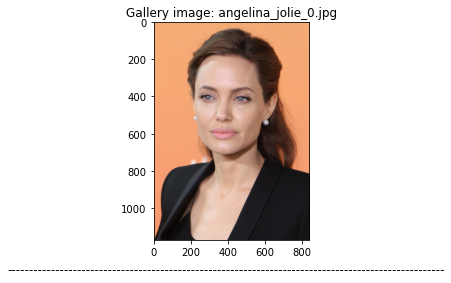

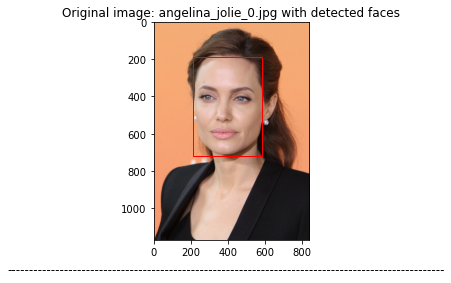

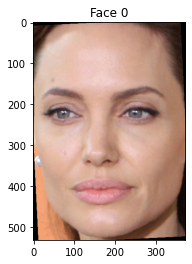

In [9]:
# We will create a unique identifier variable to keep track of each unique face
unique_id = 0

# First, let's ensure that the gallery (reference) image has only one person
# We will use just one reference image in this example
ref_img = WEB_IMG_PATHS[0]
plt.imshow(mpimg.imread(ref_img));
plt.title('Gallery image: ' + ref_img.split('/')[-1])
plt.figtext(0.5, 0.01, '-' * 100, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

# Now let's detect the face and save it in the gallery. We will use the
# 'retinaface' face detector and save the image already algined
output = detect_faces(ref_img, detector_backend=BACKENDS[4], align=True, return_type='both')

# Let's plot the original image with an overlay
fig1a, ax = plt.subplots()
ax.imshow(mpimg.imread(ref_img));
ax.set_title('Original image: ' + ref_img.split('/')[-1] + ' with detected faces')
plt.figtext(0.5, 0.01, '-' * 100, wrap=True, horizontalalignment='center', fontsize=12)

for face, roi in zip(output['faces'], output['regions']):
    rect = patches.Rectangle((roi[0], roi[1]), roi[2], roi[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
plt.show()

# ... and each detected face individually
fig1b, ax = plt.subplots(1, len(output['faces']))
ax.imshow(face[:, :, ::-1])
ax.set_title(f'Face 0')

plt.show()

# Let's save the face in the gallery directory and set it as the database path
for face in output['faces']:
    exact_path = os.path.join(gallery_path, f'face_{unique_id}.jpg')
    mpimg.imsave(exact_path, face[:, :, ::-1])
    unique_id += 1

db_path = WEB_IMGS_GALLERY


Now we will repeat the same process with the *wild* (unknown) images

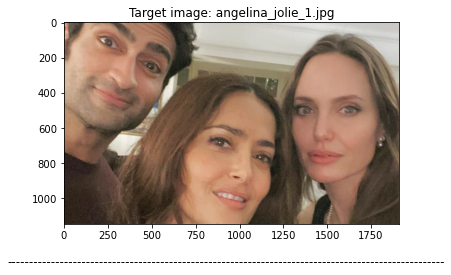

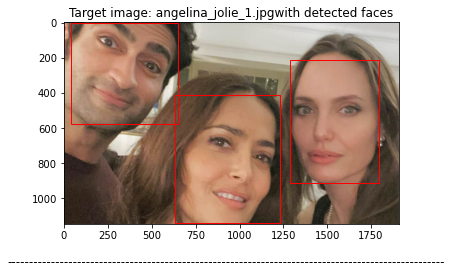

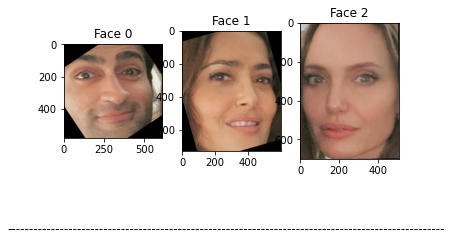

In [10]:
# Now let's investigate the wild image
tgt_img = WEB_IMG_PATHS[1] # let's use the first wild image as an example
plt.imshow(mpimg.imread(tgt_img));
plt.title('Target image: ' + tgt_img.split('/')[-1])
plt.figtext(0.5, 0.01, '-' * 100, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

# There are multiple faces in the wild image, so let's run the face detector to
# detect all faces. We will use the 'retinaface' face detector (BACKENDS[4])
output = detect_faces(tgt_img, detector_backend=BACKENDS[4], align=True, return_type='both')

# Let's plot the detected faces overlaid on the original image...
fig2a, ax = plt.subplots()
ax.imshow(mpimg.imread(tgt_img));
ax.set_title('Target image: ' + tgt_img.split('/')[-1] + 'with detected faces')
plt.figtext(0.5, 0.01, '-' * 100, wrap=True, horizontalalignment='center', fontsize=12)

for face, roi in zip(output['faces'], output['regions']):
    rect = patches.Rectangle((roi[0], roi[1]), roi[2], roi[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
plt.show()

# ... and each detected face individually
fig2b, axs = plt.subplots(1, len(output['faces']))
for i, face in enumerate(output['faces']):
    axs[i].imshow(face[:, :, ::-1])
    axs[i].set_title(f'Face {i}')
plt.figtext(0.5, 0.01, '-' * 100, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

# Now let's save these faces in the 'wild'
for face in output['faces']:
    exact_path = os.path.join(targets_path, f'face_{unique_id}.jpg')
    mpimg.imsave(exact_path, face[:, :, ::-1])
    unique_id += 1

# ... and repeat the process for the remaining images
for img_path in WEB_IMG_PATHS[2:]:
    output = detect_faces(img_path, detector_backend=BACKENDS[4], align=True, return_type='faces')
    
    for face in output['faces']:
        exact_path = os.path.join(targets_path, f'face_{unique_id}.jpg')
        mpimg.imsave(exact_path, face[:, :, ::-1])
        unique_id += 1

### 2. Initialize input:

In [11]:
img_paths, bulkProcess = functions.initialize_input(get_image_paths(WEB_IMGS_TARGETS))

print(f'Image paths:')
for pth in img_paths:
    print(f'{pth}')

print('-' * 80)

print(f'Is bulk process: {bulkProcess}')

Image paths:
/home/studio-lab-user/datasets/web_imgs/targets/face_1.jpg
/home/studio-lab-user/datasets/web_imgs/targets/face_2.jpg
/home/studio-lab-user/datasets/web_imgs/targets/face_3.jpg
/home/studio-lab-user/datasets/web_imgs/targets/face_4.jpg
/home/studio-lab-user/datasets/web_imgs/targets/face_5.jpg
/home/studio-lab-user/datasets/web_imgs/targets/face_6.jpg
/home/studio-lab-user/datasets/web_imgs/targets/face_7.jpg
/home/studio-lab-user/datasets/web_imgs/targets/face_8.jpg
/home/studio-lab-user/datasets/web_imgs/targets/face_9.jpg
/home/studio-lab-user/datasets/web_imgs/targets/face_10.jpg
/home/studio-lab-user/datasets/web_imgs/targets/face_11.jpg
/home/studio-lab-user/datasets/web_imgs/targets/face_12.jpg
--------------------------------------------------------------------------------
Is bulk process: True


### 3. Building face verifier

In [12]:
model_name, metric_names, model = build_face_verifier(model_name='ArcFace', model=None) # build face verifier
model_name = model_name[0]
model      = model[model_name]

input_shape_x, input_shape_y = functions.find_input_shape(model)

print('Model name:'.ljust(14) + f'{model_name}')
print('Metric:'.ljust(14) + f'{metric_names}')
print('Model dict:'.ljust(14) + f'{model}')
print('Input shape:'.ljust(14) + f'(X:{input_shape_x}, Y:{input_shape_y})')

Model name:   ArcFace
Metric:       ['cosine']
Model dict:   <keras.engine.functional.Functional object at 0x7f618c50aa60>
Input shape:  (X:112, Y:112)


### 4. Create representations

In [13]:
# Calculates the representations of images in the gallery
gallery_reps, unique_id = calc_representations(get_image_paths(db_path),
                                model_name=model_name, model=model,
                                grayscale=False, align=True,
                                normalization='base', unique_id_start=0)

print('  > (Gallery) representations  summary:\n')
for rep in gallery_reps:
    rep.show_info()
    print('')
print('-' * 80, '\n')

# Calculates the representations of images in the gallery
targets_reps, unique_id = calc_representations(img_paths,
                                model_name=model_name, model=model,
                                grayscale=False, align=True,
                                normalization='base', unique_id_start=unique_id)

print('  > (Targets) representations  summary:\n')
for rep in targets_reps:
    rep.show_info()
    print('')
print('-' * 80, '\n')

  > (Gallery) representations  summary:

Unique ID                : 0
Original image name      : face_0.jpg
Original image full path : /home/studio-lab-user/datasets/web_imgs/gallery/face_0.jpg
Embeddings:
  > ArcFace: [-0.00014728959649801254, 0.2856800854206085, 0.14197997748851776, ... , 0.31205201148986816] (len=512)

-------------------------------------------------------------------------------- 

  > (Targets) representations  summary:

Unique ID                : 1
Original image name      : face_1.jpg
Original image full path : /home/studio-lab-user/datasets/web_imgs/targets/face_1.jpg
Embeddings:
  > ArcFace: [0.003951393999159336, 0.23904237151145935, 0.3016446530818939, ... , -0.04331040009856224] (len=512)

Unique ID                : 2
Original image name      : face_2.jpg
Original image full path : /home/studio-lab-user/datasets/web_imgs/targets/face_2.jpg
Embeddings:
  > ArcFace: [-0.08873771131038666, 0.11419828236103058, 0.08829149603843689, ... , -0.1785959154367447] (

### 5. Verify faces

In [15]:
# Verify (recognize) faces by comparing their representations
resp_objs, toc = verify_from_reps(targets_reps, gallery_reps, model_names=model_name, distance_metrics=['cosine'], threshold=-1, prog_bar=True)

Verification: 100%|██████████| 12/12 [00:00<00:00, 3432.33it/s]


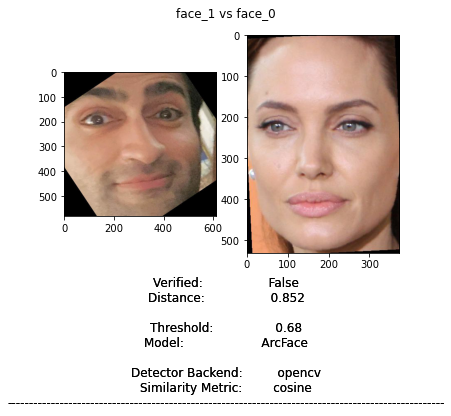

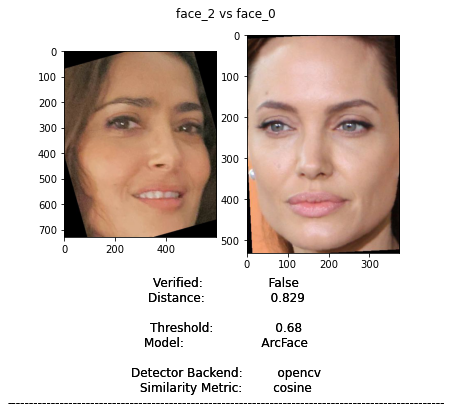

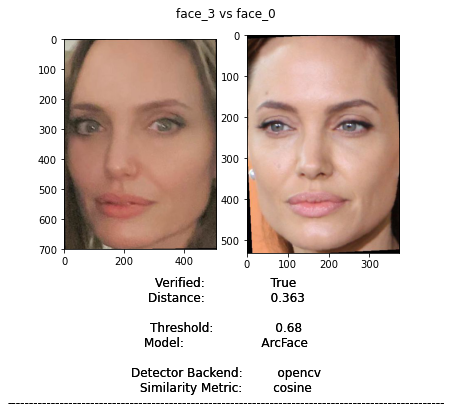

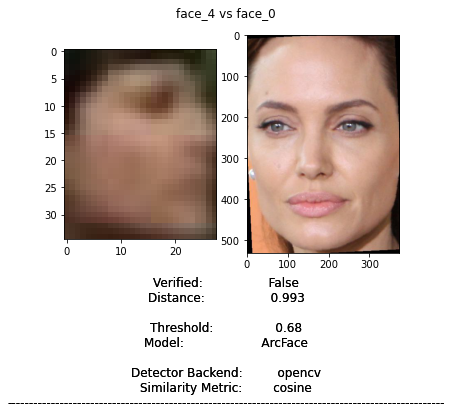

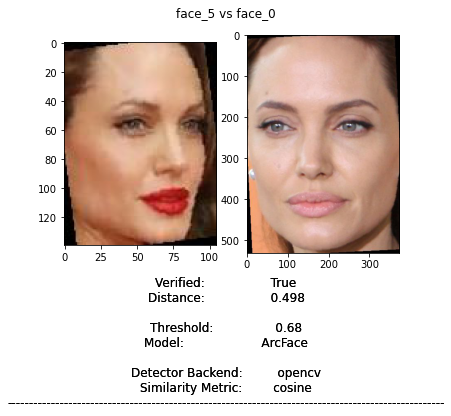

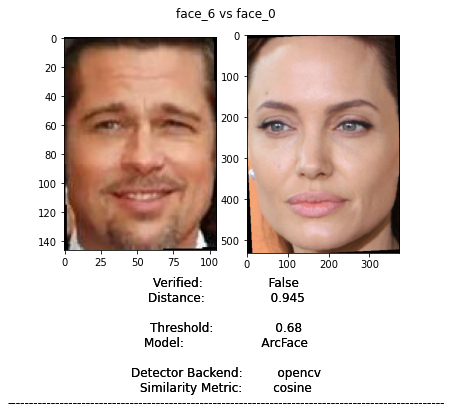

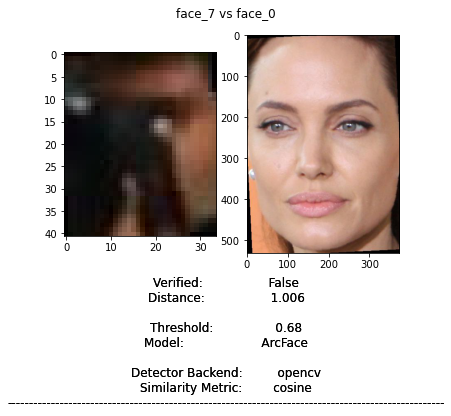

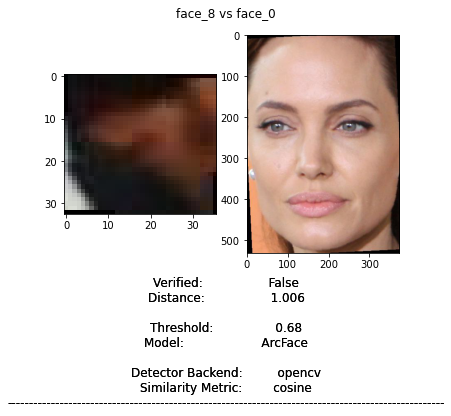

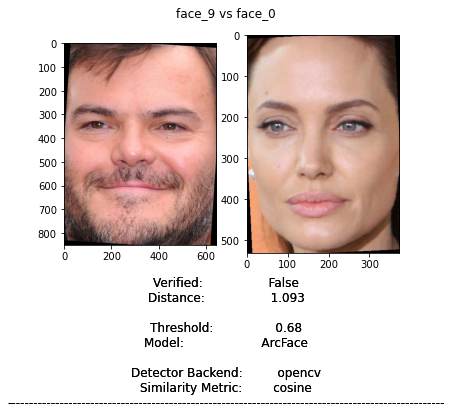

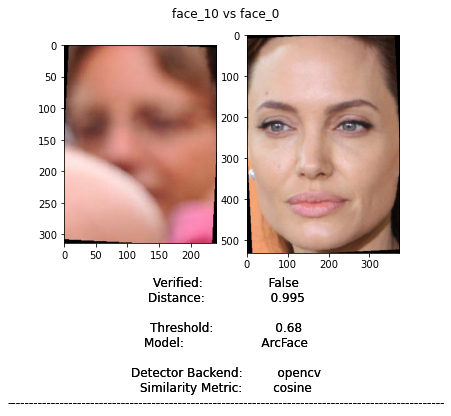

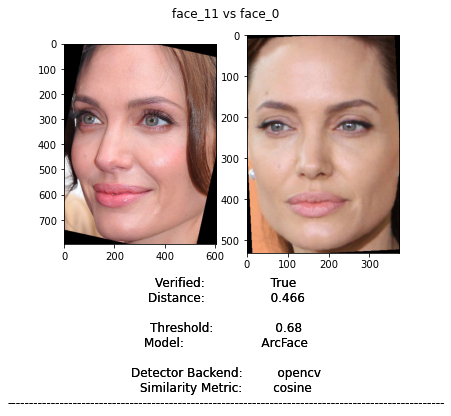

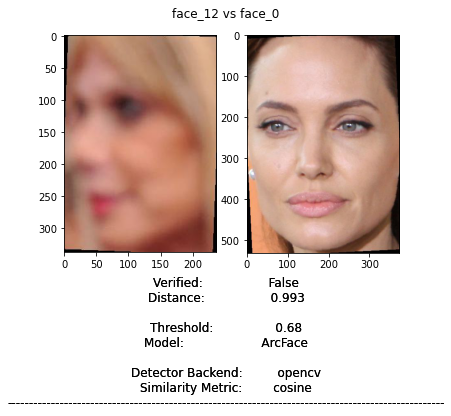

In [16]:
# Let's plot the 12 response objects (which are just dictionaries)
n_tgts = len(targets_reps)
n_gall = len(gallery_reps)

for i, value in enumerate(resp_objs.values()):
    target_fp  = os.path.join(targets_path, value['target'])
    gallery_fp = os.path.join(gallery_path, value['ref'])
    
    fig, axs = plt.subplots(1, 2)
    plt.suptitle('{} vs {}'.format(value['target'].split('.')[0],
                                   value['ref'].split('.')[0]))
    
    txt = 'Verified:'.ljust(26)          + '{}'.format(value['verified'])          + '\n'     \
        + 'Distance:'.ljust(26)          + '{:.3f}'.format(value['distance'])      + '\n' * 2 \
        + 'Threshold:'.ljust(26)         + '{}'.format(value['threshold'])         + '\n'     \
        + 'Model:'.ljust(26)             + '{}'.format(value['model'])             + '\n' * 2 \
        + 'Detector Backend:'.ljust(26)  + '{}'.format(value['detector_backend'])  + '\n'     \
        + 'Similarity Metric:'.ljust(26) + '{}'.format(value['similarity_metric']) + '\n'     \
        + '-' * 100
    
    for j in range(2):
        if j == 0:
            axs[j].imshow(mpimg.imread(target_fp))
        else:
            axs[j].imshow(mpimg.imread(gallery_fp))
             
        plt.figtext(0.5, -0.4, txt, wrap=True,
                    horizontalalignment='center', fontsize=12)
                  
    plt.show()